## <span style="color:green"> Notebook - Inversion of composition from electrical conductivity</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

Inversion module currently involves only inverting for conductivity 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pide
from pide.inversion import conductivity_solver_single_param
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


First, let's define a temperature distribution by generating a continental geotherm with 36 mW/m^2 surface heat flow.

In [2]:
moho = 38 #km
max_depth = 250

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 36, T_0 =25.0,max_depth = max_depth, moho = moho)

Let's call a pide object and define the thermal and compositional environment. In this example we use a lherzolite matrix, and Hashin-Shtrikman Lower Bound for phase-mixing coefficient.

In [3]:
p_obj = pide.pide() #creating the initial object
p_obj.set_temperature(T)
p_obj.set_pressure(p)

p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_solid_phs_mix_method(2) #Hashin-Shtrikman


Now, let's define the thermodynamics of water in the mantle. We choose the mantle water solubility functions of olivine from Padron-Navarta2017. We chose the rest to be determined through olivine model and water partition coefficients that are set. At the and we also add revalue_arrays command to add to compensate for the parameters (e.g., xFe) but needs to be adjusted to the length of the temperature and pressure array. This can be done with **revalue_arrays** method.

In [4]:
p_obj.set_mantle_water_solubility(ol = 4,opx = 3, cpx = 0, garnet = 0)
p_obj.set_mantle_water_partitions(opx_ol = 3, cpx_ol = 4, garnet_ol = 0)
p_obj.revalue_arrays()

Here, we calculate the water solubility of the environment we set up. Padron-Navarta2017 model requires Titanium in olivine parameter (wt.) to be set as ti_ol in pide. We use a conservative amount of Ti content of 0.01 (after [Foley et al. 2013; EPSL)](https://doi.org/10.1016/j.epsl.2012.11.025).

In [5]:
p_obj.set_parameter('ti_ol', 0.01)
max_water = p_obj.calculate_bulk_mantle_water_solubility(method = 'array')

In the next cell we are just creating a layered MT model with changing resistivities in $\Omega m$.

In [6]:
cond_list_to_invert = np.ones(len(T)) * 1e4 #first 75 km, just creating a array to change the rest.
cond_list_to_invert[75:100] = 1000 #from 75 to 100 km
cond_list_to_invert[100:150] = 100 #from 100 to 150 km
cond_list_to_invert[150:] = 50 #from 150 to 250 km.
cond_list_to_invert = 1.0 / cond_list_to_invert #converting to conductivity

Inversion procedure can be carried out by utilising the **conductivity_solver_single_param** method. It conducts a simple grid-search algorithm to reach the minimum misfit. This method calls for the object name (object: pide object), conductivity list to invert for (cond_list: np.ndarray or list), parameter name to invert (param_name: str), uppermost values of the search region (upper_limit_list: np.ndarray or list), lowest values of the search region (lower_limit_list: np.ndarray or list), initial grid search increment value (search_start), acceptence misfit value to stop grid-search (acceptence_threshold), and number or cpus to parallelize the algorithm. The search increment decreases by a factor of 0.5 at each sign change in misfit calculation until it reaches the acceptence threshold value. The function will return the solution values and residual list.

In [7]:
c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert,
param_name = 'bulk_water', upper_limit_list = max_water, lower_limit_list= np.zeros(len(max_water)),
search_start = 30, acceptence_threshold = 0.5, num_cpu = 5)

Inversion process has started..


Now let's plot our results.

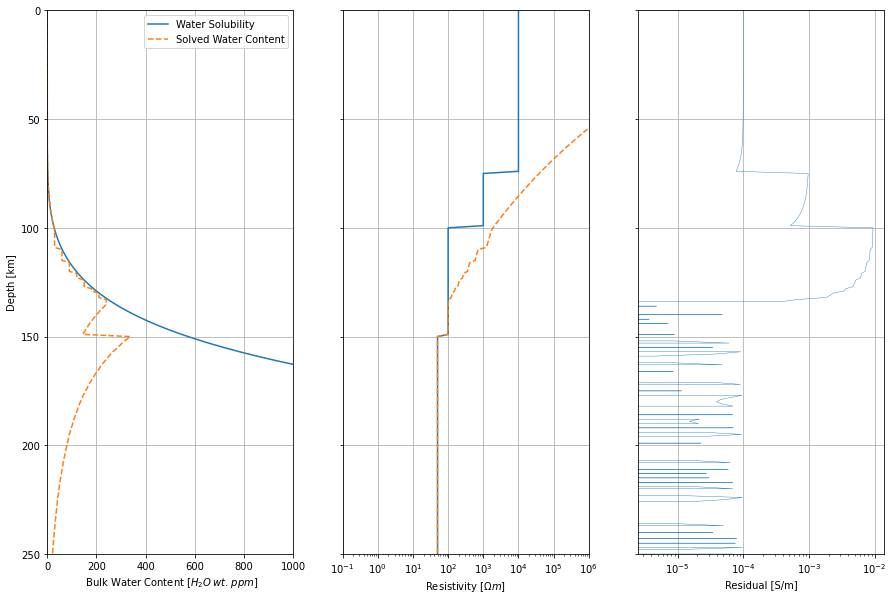

In [8]:
p_obj.set_bulk_water(c_list)
p_obj.mantle_water_distribute(method = 'array')
cond_calced = p_obj.calculate_conductivity(method = 'array')

fig = plt.figure(figsize = (15,10))
ax = plt.subplot(131)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')
ax.plot(max_water,depth, label = 'Water Solubility')
ax.plot(c_list,depth,linestyle = '--', label = 'Solved Water Content')
ax.set_ylim(np.amax(depth),np.amin(depth))
ax.set_xlim(0,1000)
ax.set_ylabel('Depth [km]')
ax.set_xlabel(r' Bulk Water Content [$H_2O \, wt. \, ppm$]')
ax.legend()
ax.grid()

ax2 = plt.subplot(132)
ax2.plot(1.0/cond_list_to_invert,depth)
ax2.plot(1.0/cond_calced,depth,linestyle = '--')
ax2.set_xscale('log')
ax2.set_ylim(np.amax(depth),np.amin(depth))
ax2.set_xlim(0.1,1e6)
ax2.set_yticklabels([])
ax2.set_xlabel(r'Resistivity [$\Omega m$]')
ax2.grid()

ax3 = plt.subplot(133)
ax3.plot(residual_list, depth, lw = 0.4)
ax3.set_ylim(np.amax(depth),np.amin(depth))
ax3.set_yticklabels([])
ax3.set_xlabel('Residual [S/m]')
ax3.set_xscale('log')
ax3.grid()

plt.show()

As it can be seen, there are large misfit values at depths above 130 kilometers. This is due to our solution space being delimited by the maximum water contents dictated by the study of Padron-Navarta2017. Conductivities here, then, has to be explained some other reason other than water content. Now let's solve the same environment for how much phlogopite needed, first let's reset the pide object by method **reset**. Then we will set the environment as a lherzolite matrix and Hashin-Shtrikman Upper Bound as the mixing relationship. This relationship suggests that the most conductive phase will also be the most interconnected one.

In [9]:
p_obj.reset()

p_obj.set_temperature(T)
p_obj.set_pressure(p)
p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_solid_phs_mix_method(2)
p_obj.set_param1_mineral(mica = 0.52)
p_obj.revalue_arrays()

Now, let's solve for phlogopite content as put in the pide as mica_frac. Setting the inversion as search start increment of 0.01 fraction to search between 0 to 0.2 fraction.

In [10]:
c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert,
param_name = 'mica_frac', upper_limit_list = np.ones(len(T)) * 0.2,lower_limit_list= np.zeros(len(T)),
search_start = 0.01, acceptence_threshold = 0.001, num_cpu = 4)

cond_calced_phlg = p_obj.calculate_conductivity()

Inversion process has started..


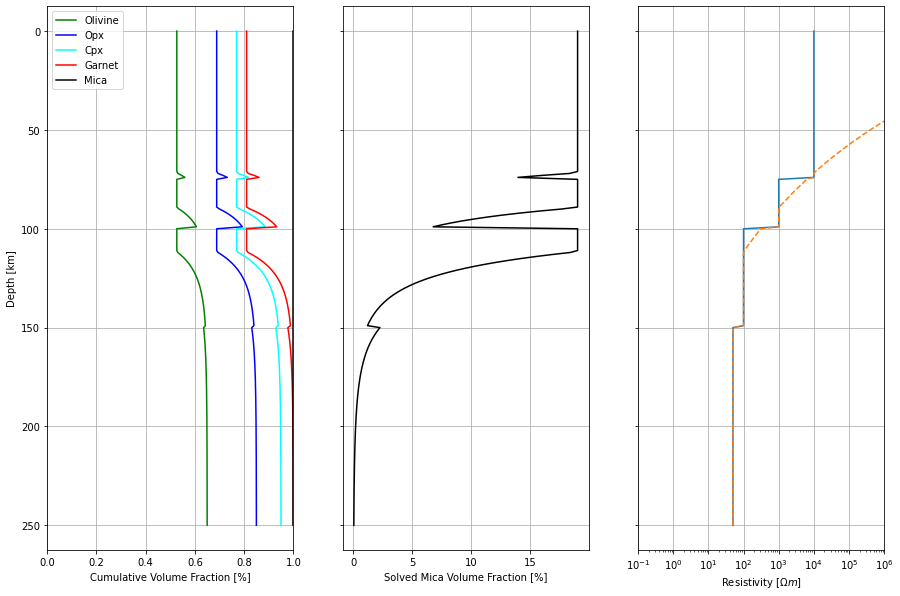

In [11]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(131)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')

ax.plot(p_obj.ol_frac,depth,color = 'g',label = 'Olivine')
ax.plot(p_obj.ol_frac + p_obj.opx_frac,depth, color = 'b',label = 'Opx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac,depth, color = 'cyan',label = 'Cpx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac,depth, color = 'r',
        label = 'Garnet')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac + p_obj.mica_frac,
        depth, color = 'k',label = 'Mica')
ax.set_xlim(0,1)
ax.legend()
ax.grid()
ax.set_xlabel('Cumulative Volume Fraction [%]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()


ax2 = plt.subplot(132)
ax2.plot(p_obj.mica_frac * 1e2, depth, color = 'k')
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.grid()
ax2.set_xlabel('Solved Mica Volume Fraction [%]')

# plt.savefig('2.png',dpi = 300)

ax3 = plt.subplot(133)
ax3.plot(1.0/cond_list_to_invert,depth)
ax3.plot(1.0/cond_calced_phlg,depth, linestyle = '--')
ax3.set_xscale('log')
ax3.set_yticklabels([])
ax3.invert_yaxis()
ax3.set_xlabel(r'Resistivity [$\Omega m$]')
ax3.grid()
ax3.set_xlim(0.1,1e6)
plt.show()

As we can see from this figure, the solution cannot be found after 150 km, because even the tiniest fraction of phlogopite will cause the conductivities to be resulting in negative misfit. At the end the algorithm gets out of the phlogopite and just solves for 0 fraction of phlogopite. This problem can be overcame by setting the keyword argument ***low_value_threshold*** to a value to assume that the solved parameter will be zero. Let's assume all solved values below 0.005 to be 0.

In [12]:
p_obj.reset()

p_obj.set_temperature(T)
p_obj.set_pressure(p)
p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_solid_phs_mix_method(2)
p_obj.set_param1_mineral(mica = 0.52)
p_obj.revalue_arrays()

c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert,
param_name = 'mica_frac', upper_limit_list = np.ones(len(T)) * 0.2,lower_limit_list= np.zeros(len(T)),
search_start = 0.01, acceptence_threshold = 0.001, num_cpu = 4, low_value_threshold = 0.005)

cond_calced_phlg = p_obj.calculate_conductivity()

Inversion process has started..


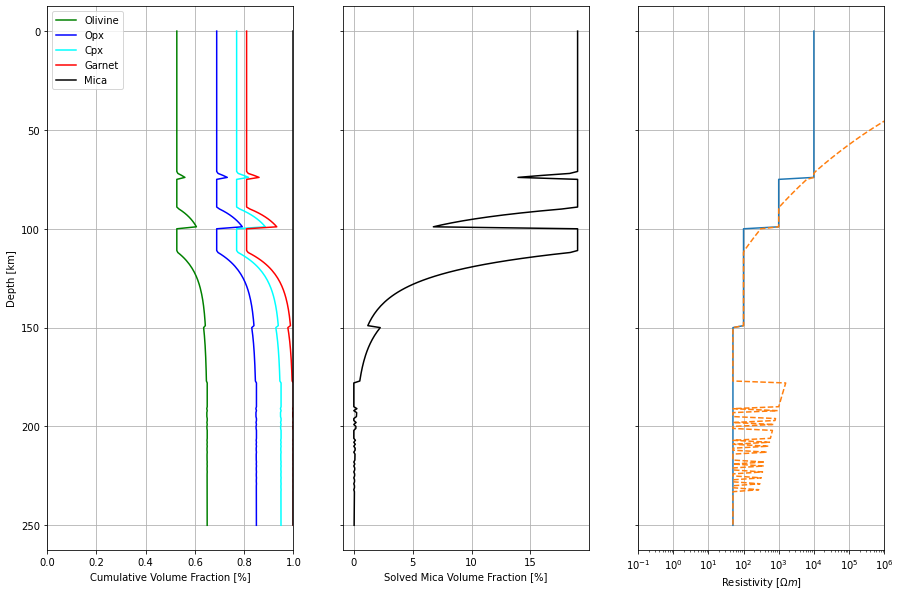

In [13]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(131)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')

ax.plot(p_obj.ol_frac,depth,color = 'g',label = 'Olivine')
ax.plot(p_obj.ol_frac + p_obj.opx_frac,depth, color = 'b',label = 'Opx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac,depth, color = 'cyan',label = 'Cpx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac,depth, color = 'r',
        label = 'Garnet')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac + p_obj.mica_frac,
        depth, color = 'k',label = 'Mica')
ax.set_xlim(0,1)
ax.legend()
ax.grid()
ax.set_xlabel('Cumulative Volume Fraction [%]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()


ax2 = plt.subplot(132)
ax2.plot(p_obj.mica_frac * 1e2, depth, color = 'k')
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.grid()
ax2.set_xlabel('Solved Mica Volume Fraction [%]')

# plt.savefig('2.png',dpi = 300)

ax3 = plt.subplot(133)
ax3.plot(1.0/cond_list_to_invert,depth)
ax3.plot(1.0/cond_calced_phlg,depth, linestyle = '--')
ax3.set_xscale('log')
ax3.set_yticklabels([])
ax3.invert_yaxis()
ax3.set_xlabel(r'Resistivity [$\Omega m$]')
ax3.grid()
ax3.set_xlim(0.1,1e6)
plt.show()

Now we can see that problem is not happening anymore!